Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [25]:
# importing required packages and libraries
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [26]:
## Google drive mounting :
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# unzipping the folder
import zipfile
with zipfile.ZipFile('/content/gdrive/My Drive/CNN_assignment.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/gdrive/My Drive/')

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [27]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path('/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Test/')

In [28]:
# print train and test size
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [29]:
# defining batch size, image height and image width
batch_size = 32
img_height = 180
img_width = 180

Using 80% of the images for training, and 20% for validation.

In [30]:
## train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  color_mode = "rgb",
  batch_size = batch_size,
  image_size = (img_height,img_width),
  seed = 123,
  subset = "training",
  validation_split = 0.2
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [31]:
## validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  color_mode = "rgb",
  batch_size = batch_size,
  image_size = (img_height,img_width),
  seed = 123,
  subset = "validation",
  validation_split = 0.2
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [32]:
# List out all the classes of skin cancer and store them in a list. 
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [33]:
# printing batch size
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

### Visualize the data
#### Visualize one instance of all the nine classes present in the dataset

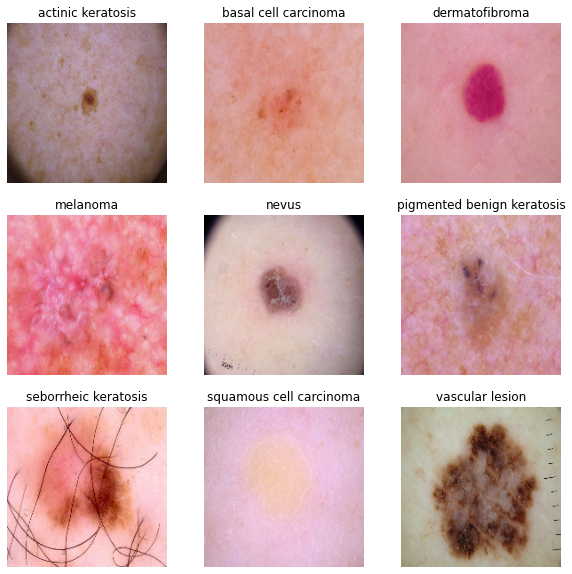

In [34]:
# code for visualizing data from each class
import glob
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[i])
    plt.axis("off")



`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [88]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Base Model Creation


In [36]:
### Creating the base model with 2-layer convolution model
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


### Compile the base model


In [37]:
### loss function = SparseCategoricalCrossentropy
# optimizer = adam
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [38]:
# View the summary of all layers of base model
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 64)       

### Train the base model

In [39]:
# epochs =20
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20,
)

Epoch 1/20
56/56 [==============================] - 16s 81ms/step - loss: 2.0207 - accuracy: 0.2232 - val_loss: 1.8421 - val_accuracy: 0.3691
Epoch 2/20
56/56 [==============================] - 1s 25ms/step - loss: 1.6165 - accuracy: 0.4481 - val_loss: 1.4590 - val_accuracy: 0.5056
Epoch 3/20
56/56 [==============================] - 1s 24ms/step - loss: 1.4253 - accuracy: 0.4989 - val_loss: 1.4815 - val_accuracy: 0.5034
Epoch 4/20
56/56 [==============================] - 1s 24ms/step - loss: 1.3012 - accuracy: 0.5474 - val_loss: 1.3652 - val_accuracy: 0.5257
Epoch 5/20
56/56 [==============================] - 1s 24ms/step - loss: 1.2099 - accuracy: 0.5798 - val_loss: 1.4124 - val_accuracy: 0.5481
Epoch 6/20
56/56 [==============================] - 1s 24ms/step - loss: 1.1644 - accuracy: 0.5898 - val_loss: 1.3110 - val_accuracy: 0.5615
Epoch 7/20
56/56 [==============================] - 2s 28ms/step - loss: 1.0733 - accuracy: 0.6233 - val_loss: 1.4763 - val_accuracy: 0.5145
Epoch 8/20
5

### Visualizing training results of base model

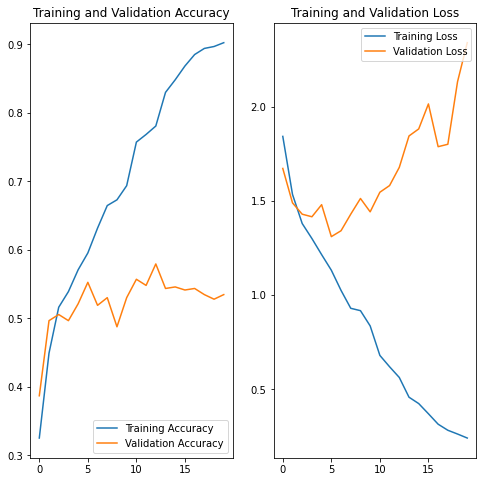

In [17]:
# visualizing training accuracy and validation accuracy
# visualizing training loss and validation loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings:
1. We can see the training accuracy as ~89% but validation accuracy is ~54% which indicated overfitting
2. Training loss is also less and validation loss is more which also indicates overfitting
3. In the next step we are going to add augmentation layer and dropout layer to tackle overfitting issue.

### Model 2 with Augmentation layer and dropout layer

In [40]:
#  Augmentation Layer
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

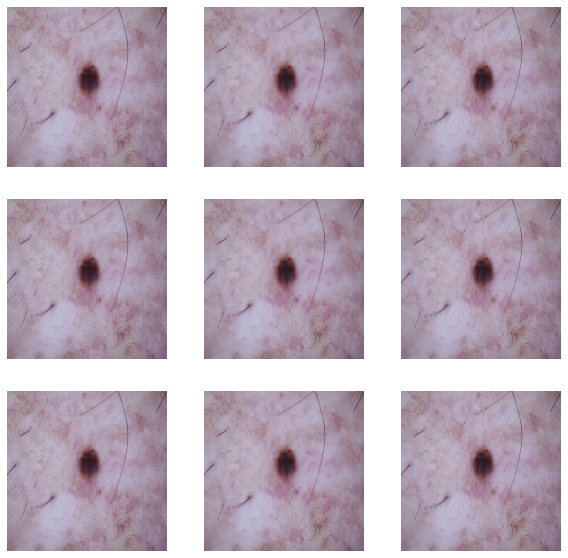

In [41]:
# visualize how augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Create model 2 with augmentation layer and dropout layer


In [42]:
#Creating a new neural network with tf.keras.layers.Dropout before training it using the augmented images:


model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

### Compiling the model 2

In [43]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [44]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

### Training the model 2

In [45]:
# train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 4s 47ms/step - loss: 2.1421 - accuracy: 0.2249 - val_loss: 1.9159 - val_accuracy: 0.2998
Epoch 2/20
56/56 [==============================] - 2s 41ms/step - loss: 1.9076 - accuracy: 0.2997 - val_loss: 1.9377 - val_accuracy: 0.2752
Epoch 3/20
56/56 [==============================] - 2s 41ms/step - loss: 1.8157 - accuracy: 0.3287 - val_loss: 1.6595 - val_accuracy: 0.3691
Epoch 4/20
56/56 [==============================] - 2s 41ms/step - loss: 1.6204 - accuracy: 0.4107 - val_loss: 1.5750 - val_accuracy: 0.4474
Epoch 5/20
56/56 [==============================] - 2s 40ms/step - loss: 1.4775 - accuracy: 0.4844 - val_loss: 1.4074 - val_accuracy: 0.5302
Epoch 6/20
56/56 [==============================] - 2s 40ms/step - loss: 1.5076 - accuracy: 0.4727 - val_loss: 1.4037 - val_accuracy: 0.5190
Epoch 7/20
56/56 [==============================] - 2s 41ms/step - loss: 1.4220 - accuracy: 0.4994 - val_loss: 1.4724 - val_accuracy: 0.4922
Epoch 8/20
56

### Visualizing the results of model 2

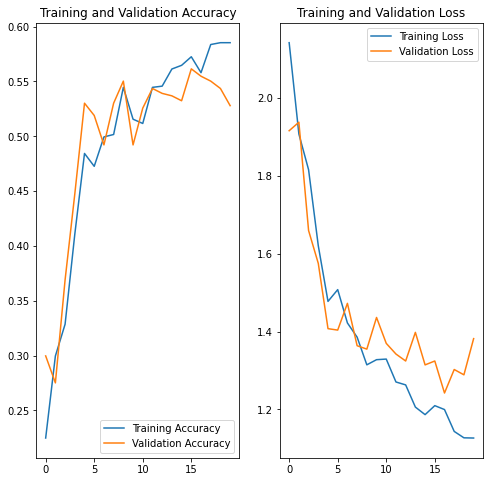

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings: We can see the improvement from the last model as this model is less overfitted. But We can still see the accuracy of model is not that good. There must be a class imbalance or the model is too simple to understand the pattern in the data.  
##### In the next part we are going to increase the sample of each class by 500, so the classes are not sparse. 



#### Checking the distribution of classes in the dataset

In [47]:
import os

for i in class_names:
  sub_folder = i+'/'
  path = os.path.join(data_dir_train,sub_folder)
  lst = os.listdir(path) # your directory path
  number_files = len(lst)
  print('Number of images in {0} class is {1}'.format(i,number_files))




Number of images in actinic keratosis class is 114
Number of images in basal cell carcinoma class is 376
Number of images in dermatofibroma class is 95
Number of images in melanoma class is 438
Number of images in nevus class is 357
Number of images in pigmented benign keratosis class is 462
Number of images in seborrheic keratosis class is 77
Number of images in squamous cell carcinoma class is 181
Number of images in vascular lesion class is 139


#### Findings 
#### - Class which has the least number of samples=> Seborrheic Keratosis (77 Images)
#### - Classes dominate the data in terms proportionate number of samples => basal cell carcinoma(376 images), Melanoma(438 images), Nevus (357 Images), Pigmented benign keratosis(462 Images)


#### Data Augmentation
#### **Context:** Using a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [48]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [49]:
# path_to_training_dataset= data_dir_train
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline('/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/' + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FA6222D2410>: 100%|██████████| 500/500 [00:18<00:00, 26.63 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FA6706316D0>: 100%|██████████| 500/500 [00:18<00:00, 27.40 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA62227FE50>: 100%|██████████| 500/500 [00:18<00:00, 27.56 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=722x542 at 0x7FA6876AB610>: 100%|██████████| 500/500 [01:34<00:00,  5.29 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7FA6223EF650>: 100%|██████████| 500/500 [01:26<00:00,  5.78 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA68749C6D0>: 100%|██████████| 500/500 [00:18<00:00, 27.54 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FA60AD8E610>: 100%|██████████| 500/500 [00:43<00:00, 11.53 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA687620E50>: 100%|██████████| 500/500 [00:17<00:00, 28.03 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FA6874C7DD0>: 100%|██████████| 500/500 [00:18<00:00, 27.24 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [51]:
# number of augmented images
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [52]:
# creating a path list of augmented images
path_list = [x for x in data_dir_train.glob('*/output/*.jpg')]

# creating the labels for augmneted images
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in data_dir_train.glob('*/output/*.jpg')]

# dataframe creation from above lists
dataframe_dict_new = dict(zip(path_list, lesion_list_new))
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
print(df2['Label'].value_counts())

actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: Label, dtype: int64


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [53]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset for augmented data

In [54]:
data_dir_train=data_dir_train 
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


####  Create a validation dataset  for augmented data

In [55]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


####  Creating model with augmented data

In [89]:
# model creation with 
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


####  Compile your model 3

In [90]:
## model 3 compile
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [91]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_15 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_41 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_42 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 45, 45, 32)      

####   Train your model 3

In [92]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 34s 59ms/step - loss: 1.8353 - accuracy: 0.2958 - val_loss: 1.5271 - val_accuracy: 0.4232
Epoch 2/30
169/169 [==============================] - 4s 25ms/step - loss: 1.4132 - accuracy: 0.4709 - val_loss: 1.3579 - val_accuracy: 0.5130
Epoch 3/30
169/169 [==============================] - 4s 24ms/step - loss: 1.2482 - accuracy: 0.5419 - val_loss: 1.1458 - val_accuracy: 0.5984
Epoch 4/30
169/169 [==============================] - 4s 24ms/step - loss: 1.1026 - accuracy: 0.5959 - val_loss: 1.0697 - val_accuracy: 0.6206
Epoch 5/30
169/169 [==============================] - 4s 26ms/step - loss: 0.9507 - accuracy: 0.6563 - val_loss: 0.9501 - val_accuracy: 0.6407
Epoch 6/30
169/169 [==============================] - 4s 25ms/step - loss: 0.8385 - accuracy: 0.6953 - val_loss: 0.8871 - val_accuracy: 0.7038
Epoch 7/30
169/169 [==============================] - 4s 24ms/step - loss: 0.7028 - accuracy: 0.7567 - val_loss: 1.0151 - val_accuracy: 0.649

####   Visualize the model 3 results

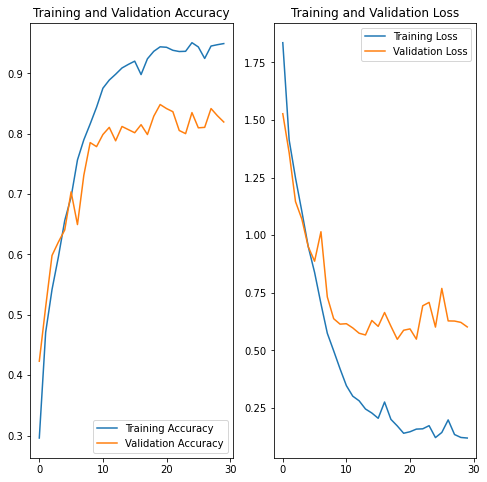

In [93]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings:
##### To some extent yes, rebalancing classes helped in reducing overfitting. But few more alteration we can do while modelling. We can use transfer learning because the dataset we are using is very small and the some pre-trained models are already trained on these kind of images where the weights are more optimized and correct compare to this model.   

